In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '49-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [25]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 16 * 8,
  "EPOCHS": 12,
  "LEARNING_RATE": 2e-5 * 8,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.00016,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [26]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [33]:
#@title
def data_augment(image, label):
    # p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    # ### Spatial-level transforms
    # if p_spatial >= .2: # flips
    #     image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
    #     image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
    #     if p_spatial >= .7:
    #         image['input_image'] = tf.image.transpose(image['input_image'])
            
    # if p_rotate >= .8: # rotate 270º
    #     image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    # elif p_rotate >= .6: # rotate 180º
    #     image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    # elif p_rotate >= .4: # rotate 90º
    #     image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    # if p_spatial2 >= .6:
    #     if p_spatial2 >= .9:
    #         image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
    #     elif p_spatial2 >= .8:
    #         image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
    #     elif p_spatial2 >= .7:
    #         image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
    #     else:
    #         image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    # if p_crop >= .6: # crops
    #     if p_crop >= .8:
    #         image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    #     elif p_crop >= .7:
    #         image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    #     else:
    #         image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
    #     image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    # if p_pixel >= .6: # Pixel-level transforms
    #     if p_pixel >= .9:
    #         image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
    #     elif p_pixel >= .8:
    #         image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
    #     elif p_pixel >= .7:
    #         image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
    #     else:
    #         image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)


    image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
    image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
    image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
    image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
    image['input_image'] = tf.image.random_crop(image['input_image'], size=[250, 250, config['CHANNELS']])
    image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
    image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
    image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
    image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
    image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)
    image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [34]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00016 to 4.19e-05


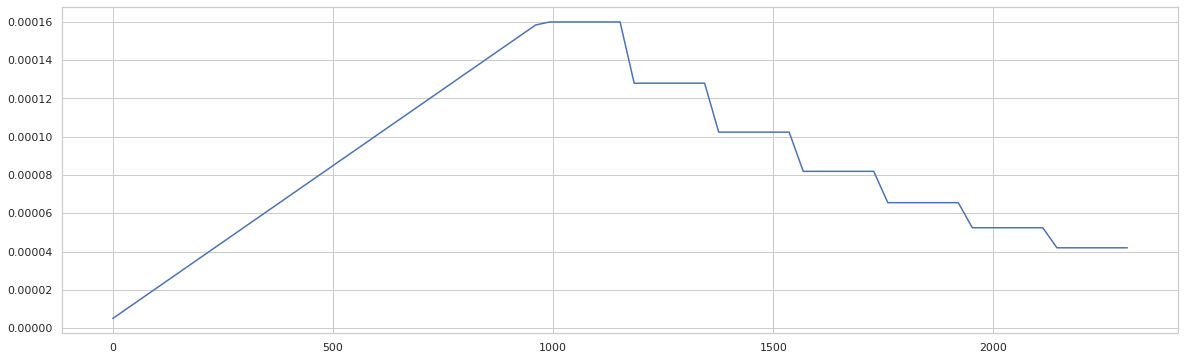

In [35]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [36]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [37]:
# Evaluation
# eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=512, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
# test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
# test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
194/194 - 97s - auc: 0.5341 - loss: 0.3764 - val_auc: 0.7290 - val_loss: 0.1764
Epoch 2/12
194/194 - 72s - auc: 0.6926 - loss: 0.1748 - val_auc: 0.8013 - val_loss: 0.1688
Epoch 3/12
194/194 - 75s - auc: 0.7793 - loss: 0.1710 - val_auc: 0.8265 - val_loss: 0.1656
Epoch 4/12
194/194 - 74s - auc: 0.8173 - loss: 0.1691 - val_auc: 0.8346 - val_loss: 0.1652
Epoch 5/12
194/194 - 73s - auc: 0.8486 - loss: 0.1666 - val_auc: 0.8389 - val_loss: 0.1642
Epoch 6/12
194/194 - 73s - auc: 0.8371 - loss: 0.1666 - val_auc: 0.8822 - val_loss: 0.1636
Epoch 7/12
194/194 - 76s - auc: 0.8697 - loss: 0.1650 - val_auc: 0.8747 - val_loss: 0.1634
Epoch 8/12
194/194 - 69s - auc: 0.8922 - loss: 0.1619 - val_auc: 0.8387 - val_loss: 0.1641
Epoch 9/12
194/194 - 68s - auc: 0.9016 - loss: 0.1602 - val_auc: 0.8494 - val_loss: 0.1643
Epoch 10/12
194/194 - 73s - auc: 0.9072 - loss: 0.1598 - val_auc: 0.8795 - val_loss: 0.1627
Epoch 11/12
194/194 - 73s - auc: 0.9300 - loss: 0.1576 - val_auc: 0.8873 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 100s - auc: 0.5246 - loss: 0.3752 - val_auc: 0.7107 - val_loss: 0.1780
Epoch 2/12
210/210 - 75s - auc: 0.7143 - loss: 0.1727 - val_auc: 0.8115 - val_loss: 0.1683
Epoch 3/12
210/210 - 78s - auc: 0.7904 - loss: 0.1702 - val_auc: 0.8491 - val_loss: 0.1663
Epoch 4/12
210/210 - 76s - auc: 0.8256 - loss: 0.1686 - val_auc: 0.8603 - val_loss: 0.1642
Epoch 5/12
210/210 - 75s - auc: 0.8534 - loss: 0.1656 - val_auc: 0.8571 - val_loss: 0.1633
Epoch 6/12
210/210 - 78s - auc: 0.8549 - loss: 0.1654 - val_auc: 0.8633 - val_loss: 0.1632
Epoch 7/12
210/210 - 72s - auc: 0.8843 - loss: 0.1626 - val_auc: 0.8701 - val_loss: 0.1646
Epoch 8/12
210/210 - 76s - auc: 0.8795 - loss: 0.1624 - val_auc: 0.9022 - val_loss: 0.1599
Epoch 9/12
210/210 - 70s - auc: 0.9044 - loss: 0.1592 - val_auc: 0.8729 - val_loss: 0.1610
Epoch 10/12
210/210 - 79s - auc: 0.9159 - loss: 0.1590 - val_auc: 0.8757 - val_loss: 0.1596
Epoch 11/12
210/210 - 77s - auc: 0.9245 - loss: 0.1570 - val_auc: 0.8974 - val_loss: 0.1

INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.229.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 101s - auc: 0.5253 - loss: 0.3665 - val_auc: 0.7427 - val_loss: 0.1768
Epoch 2/12
210/210 - 76s - auc: 0.7140 - loss: 0.1727 - val_auc: 0.8024 - val_loss: 0.1705
Epoch 3/12
210/210 - 78s - auc: 0.7705 - loss: 0.1704 - val_auc: 0.8525 - val_loss: 0.1685
Epoch 4/12
210/210 - 77s - auc: 0.8035 - loss: 0.1678 - val_auc: 0.8717 - val_loss: 0.1666
Epoch 5/12
210/210 - 70s - auc: 0.8365 - loss: 0.1670 - val_auc: 0.8439 - val_loss: 0.1682
Epoch 6/12
210/210 - 79s - auc: 0.8653 - loss: 0.1646 - val_auc: 0.8455 - val_loss: 0.1656
Epoch 7/12
210/210 - 72s - auc: 0.8690 - loss: 0.1638 - val_auc: 0.8518 - val_loss: 0.1665
Epoch 8/12
210/210 - 77s - auc: 0.8879 - loss: 0.1618 - val_auc: 0.8601 - val_loss: 0.1638
Epoch 9/12
210/210 - 76s - auc: 0.9088 - loss: 0.1605 - val_auc: 0.8563 - val_loss: 0.1636
Epoch 10/12
210/210 - 79s - auc: 0.9092 - loss: 0.1585 - val_auc: 0.8551 - val_loss: 0.1630
Epoch 11/12
210/210 - 72s - auc: 0.9185 - loss: 0.1571 - val_auc: 0.8730 - val_loss: 0.1

## Model loss graph

Fold: 1


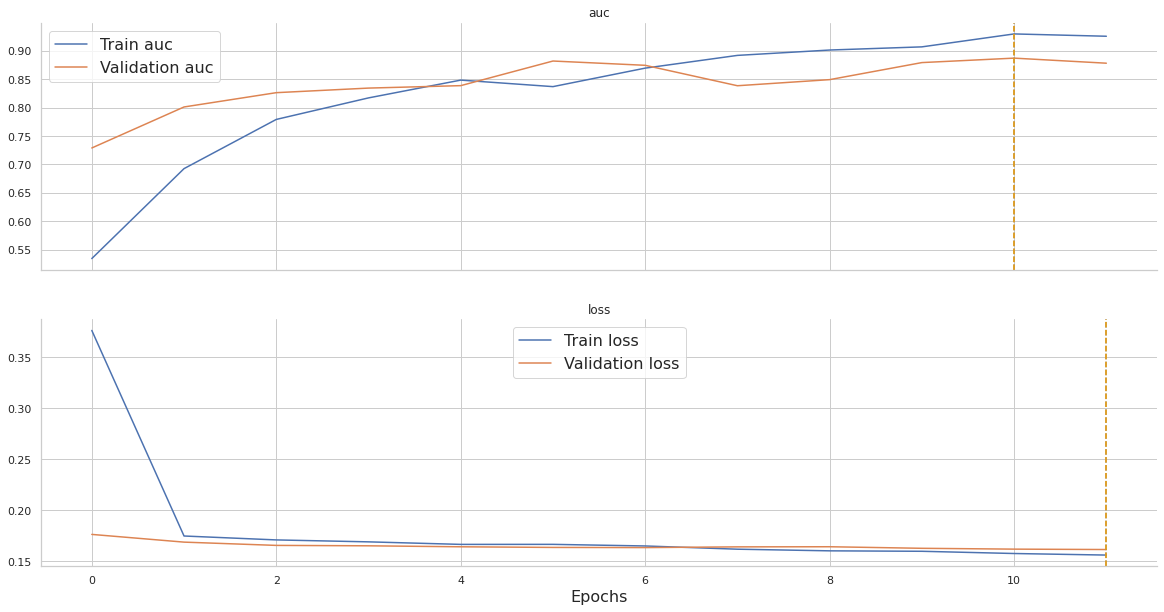

Fold: 2


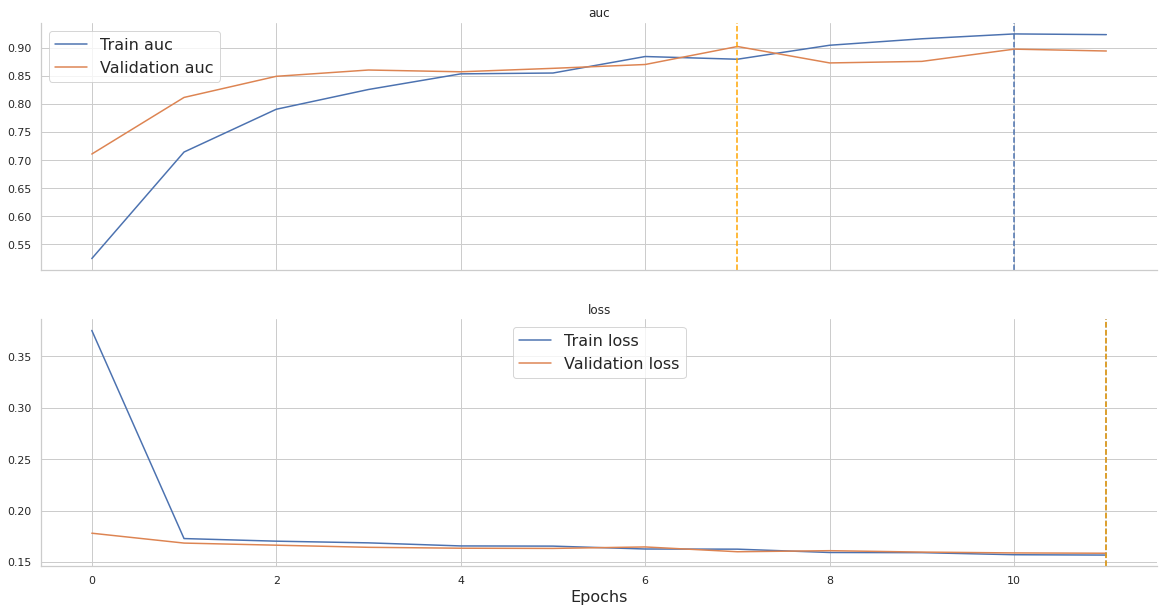

Fold: 3


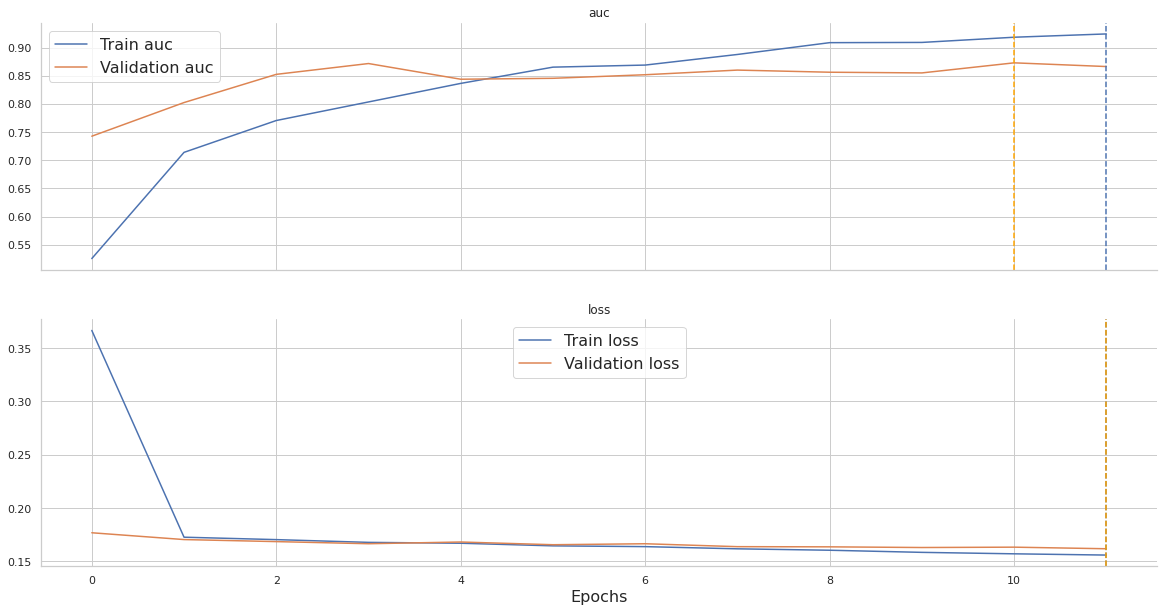

In [38]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

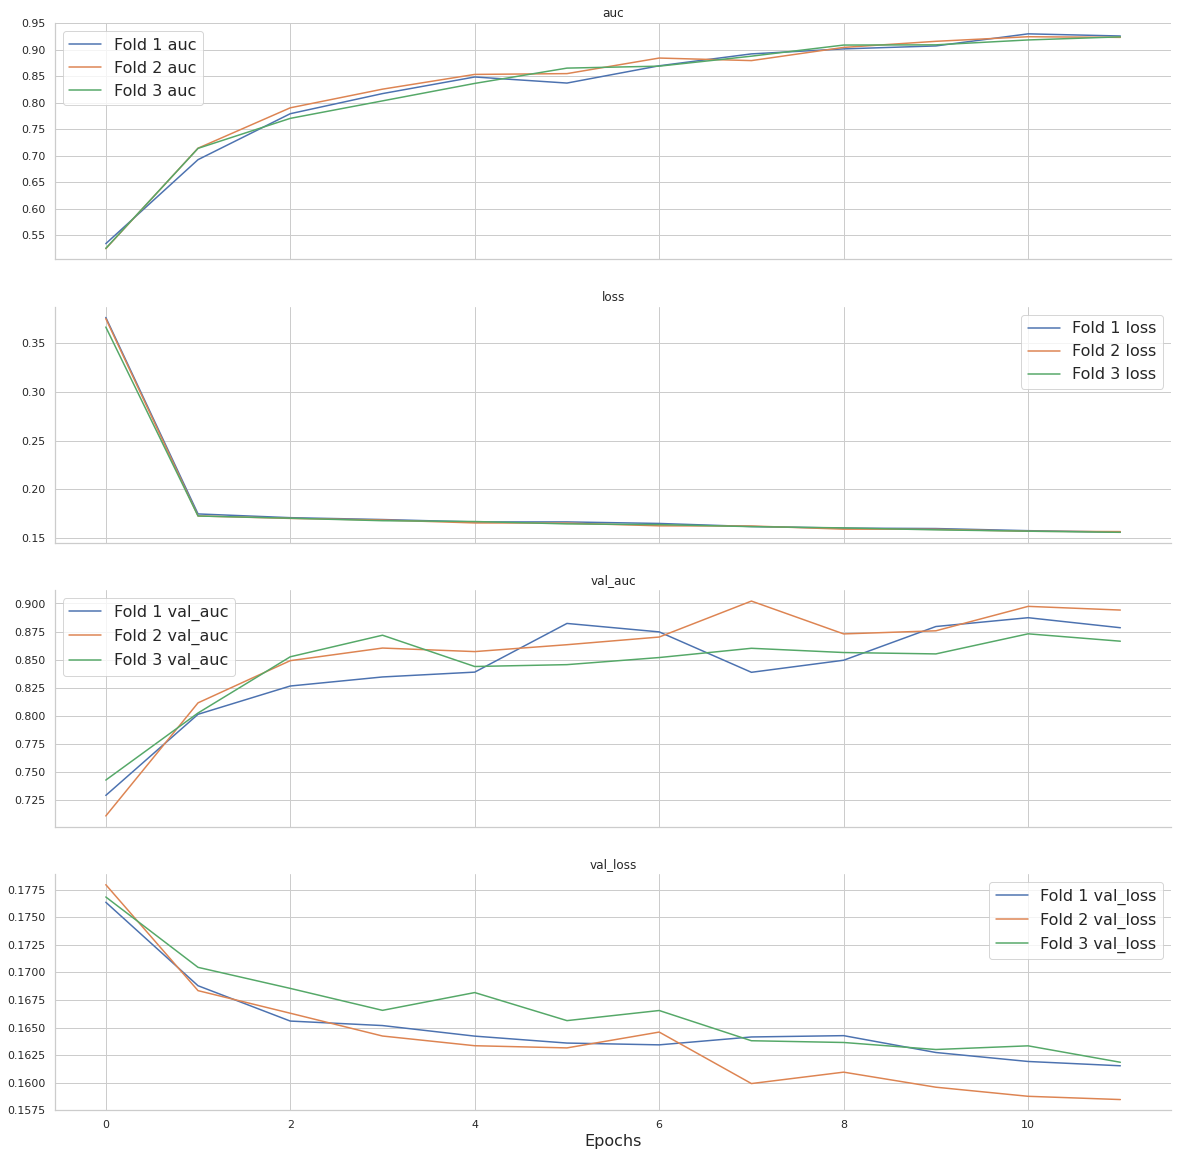

In [39]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [40]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.960898,0.881208,0.079690,0.965378,0.880180,0.951878,0.897423,0.965437,0.866021
Accuracy,0.986207,0.982966,0.003242,0.986676,0.982859,0.986103,0.983905,0.985843,0.982134
Precision,0.901391,0.590418,0.310973,0.944444,0.481481,0.896825,0.727273,0.862903,0.562500
Recall,0.244732,0.105766,0.138966,0.268623,0.092199,0.238397,0.145455,0.227176,0.079646
F1-score,0.384869,0.178907,0.205962,0.418278,0.154762,0.376667,0.242424,0.359664,0.139535
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


# Model evaluation by Subset

In [41]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.960898,0.881208,0.079690,0.965378,0.880180,0.951878,0.897423,0.965437,0.866021
male,0.964877,0.880453,0.084424,0.968254,0.880105,0.953835,0.889177,0.972543,0.872079
female,0.954396,0.876936,0.077460,0.959735,0.879773,0.948744,0.906369,0.954708,0.844666
head/neck,0.960169,0.913487,0.046682,0.954670,0.911047,0.968029,0.884833,0.957808,0.944582
upper extremity,0.966317,0.900652,0.065666,0.970894,0.847959,0.962687,0.915885,0.965371,0.938111
lower extremity,0.944164,0.841246,0.102918,0.961215,0.818909,0.921022,0.849129,0.950256,0.855700
torso,0.964644,0.890198,0.074446,0.965739,0.913816,0.954117,0.912486,0.974077,0.844292
0 <= age < 26,0.953268,0.790392,0.162876,0.953640,0.928671,0.943958,0.748260,0.962205,0.694245
26 <= age < 40,0.959625,0.839750,0.119875,0.950442,0.889990,0.963583,0.780181,0.964849,0.849078


# Model evaluation (best)

In [42]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.960757,0.881337,0.079421,0.965432,0.880227,0.951696,0.897174,0.965144,0.866610
Accuracy,0.986119,0.982939,0.003180,0.986595,0.982617,0.986029,0.983905,0.985732,0.982295
Precision,0.891652,0.590572,0.301080,0.943548,0.444444,0.888889,0.727273,0.842520,0.600000
Recall,0.242524,0.103402,0.139122,0.264108,0.085106,0.236287,0.145455,0.227176,0.079646
F1-score,0.381297,0.175302,0.205995,0.412698,0.142857,0.373333,0.242424,0.357860,0.140625
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.960757,0.881337,0.079421,0.965432,0.880227,0.951696,0.897174,0.965144,0.866610
male,0.964956,0.881057,0.083899,0.968293,0.880884,0.953929,0.889285,0.972648,0.873003
female,0.953950,0.876542,0.077407,0.959796,0.878762,0.948172,0.905861,0.953881,0.845004
head/neck,0.959853,0.915328,0.044524,0.954684,0.910116,0.967730,0.890048,0.957144,0.945820
upper extremity,0.966367,0.901398,0.064969,0.971066,0.848781,0.962710,0.915929,0.965324,0.939484
lower extremity,0.944219,0.840304,0.103915,0.961508,0.816557,0.920894,0.848508,0.950256,0.855848
torso,0.964344,0.890176,0.074167,0.965729,0.914678,0.953830,0.911104,0.973472,0.844747
0 <= age < 26,0.953564,0.785269,0.168295,0.955500,0.925175,0.943456,0.744780,0.961734,0.685851
26 <= age < 40,0.959328,0.839047,0.120281,0.949285,0.891260,0.963434,0.776241,0.965264,0.849640


# Confusion matrix

Fold: 1


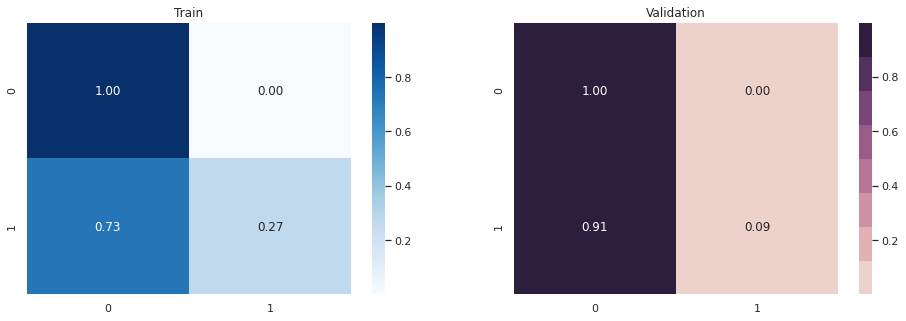

Fold: 2


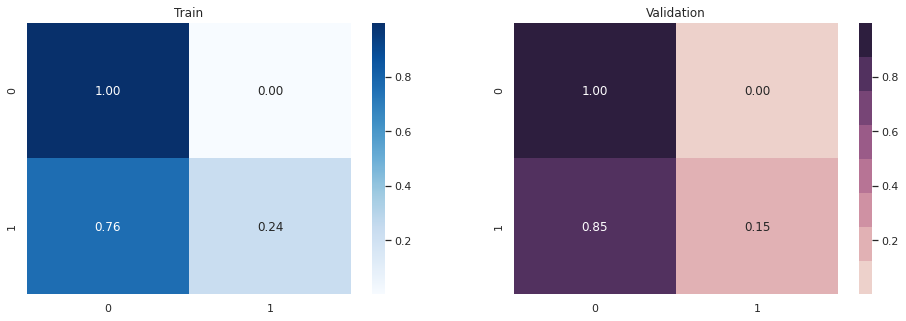

Fold: 3


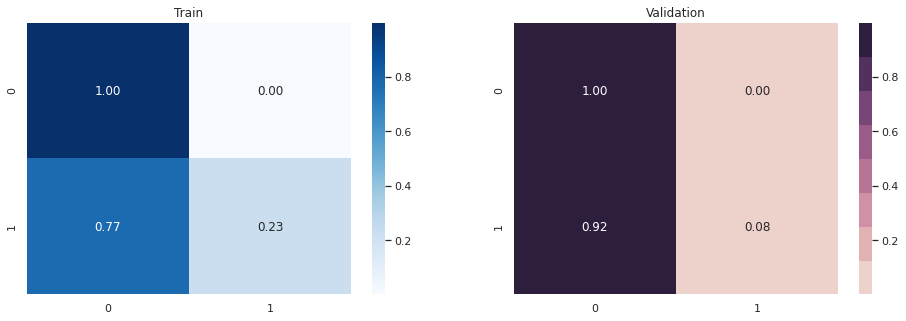

In [43]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [44]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 13
Train positive correct predictions: 13
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.021866,0.030613,0.033786,0.044929
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.015215,0.034539,0.022165,0.019372
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.016128,0.031785,0.026265,0.022589
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.025686,0.058986,0.030129,0.039317
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.013727,0.024440,0.026719,0.017475
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.015506,0.028458,0.031252,0.017820
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.019809,0.032475,0.028738,0.037831
7,ISIC_0075663,female,35.0,torso,unknown,0,0.015098,0.029447,0.023499,0.022545
8,ISIC_0075914,male,30.0,torso,unknown,0,0.015452,0.030782,0.025778,0.020701
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.018499,0.033084,0.033260,0.026149


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.023351,0.032491,0.053446,0.030820
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.110231,0.146792,0.261973,0.142391
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.018778,0.050087,0.025221,0.018580
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.082591,0.094838,0.160027,0.158090
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.051210,0.062801,0.084325,0.108922
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.234841,0.360045,0.155940,0.658218
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.080729,0.150174,0.176958,0.076514
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.050572,0.045073,0.118367,0.089417
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.084899,0.044140,0.240499,0.139855
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.031416,0.073087,0.059793,0.024202


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
3689,ISIC_1210011,male,75.0,torso,melanoma,1,0.511280,0.886156,0.836174,0.834070
3779,ISIC_1241817,male,60.0,head/neck,melanoma,1,0.509624,0.799553,0.853743,0.894825
8139,ISIC_2535541,male,80.0,head/neck,melanoma,1,0.560423,0.939288,0.933704,0.929122
9984,ISIC_3097354,male,75.0,upper extremity,melanoma,1,0.504962,0.881475,0.840344,0.802993
12991,ISIC_3996796,male,70.0,torso,melanoma,1,0.529471,0.791400,0.943251,0.912702
13009,ISIC_4000481,male,60.0,upper extremity,melanoma,1,0.545211,0.928473,0.902775,0.894805
17662,ISIC_5388184,male,80.0,head/neck,melanoma,1,0.528634,0.899915,0.907562,0.835692
18338,ISIC_5581931,male,85.0,head/neck,melanoma,1,0.512554,0.734583,0.940501,0.887687
19325,ISIC_5867911,male,55.0,upper extremity,melanoma,1,0.571440,0.963651,0.933897,0.959653
25249,ISIC_7662910,male,60.0,head/neck,melanoma,1,0.558723,0.913882,0.939372,0.940359


# Visualize test predictions

In [45]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 31|10951
Test predictions (last) 33|10949
Test predictions (tta) 59|10923
Test predictions (last tta) 57|10925
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.029804,0.029595,0.026918,0.026325
1,ISIC_0052349,male,40.0,lower extremity,0.029593,0.029296,0.026762,0.026642
2,ISIC_0058510,female,55.0,torso,0.026782,0.026709,0.024467,0.024731
3,ISIC_0073313,female,50.0,torso,0.024341,0.024452,0.028280,0.028033
4,ISIC_0073502,female,45.0,lower extremity,0.033250,0.033648,0.033183,0.033354
5,ISIC_0074618,male,50.0,lower extremity,0.028956,0.028946,0.040815,0.041179
6,ISIC_0076801,male,45.0,upper extremity,0.025597,0.025694,0.036313,0.037282
7,ISIC_0077586,male,50.0,lower extremity,0.030151,0.030067,0.038227,0.035246
8,ISIC_0082004,female,45.0,torso,0.036255,0.036027,0.031070,0.033869
9,ISIC_0082785,male,65.0,lower extremity,0.032189,0.031792,0.031818,0.031440


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.760977,0.759612,0.825909,0.809215
403,ISIC_0481105,male,80.0,torso,0.613098,0.607488,0.741028,0.740518
596,ISIC_0637104,female,80.0,torso,0.509434,0.508116,0.601045,0.587065
764,ISIC_0775584,female,35.0,lower extremity,0.730079,0.723195,0.552170,0.566708
943,ISIC_0936377,male,65.0,head/neck,0.640889,0.642976,0.663567,0.706008
1408,ISIC_1364884,female,35.0,upper extremity,0.654762,0.657444,0.541059,0.557415
1485,ISIC_1429763,male,45.0,head/neck,0.603638,0.599017,0.689489,0.673041
1677,ISIC_1593714,female,50.0,lower extremity,0.773186,0.784982,0.730487,0.741225
1764,ISIC_1670692,male,50.0,torso,0.613210,0.612018,0.591243,0.580329
2195,ISIC_2078598,male,80.0,torso,0.780636,0.784868,0.449271,0.434224


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.760977,0.759612,0.825909,0.809215
403,ISIC_0481105,male,80.0,torso,0.613098,0.607488,0.741028,0.740518
596,ISIC_0637104,female,80.0,torso,0.509434,0.508116,0.601045,0.587065
764,ISIC_0775584,female,35.0,lower extremity,0.730079,0.723195,0.552170,0.566708
943,ISIC_0936377,male,65.0,head/neck,0.640889,0.642976,0.663567,0.706008
1408,ISIC_1364884,female,35.0,upper extremity,0.654762,0.657444,0.541059,0.557415
1485,ISIC_1429763,male,45.0,head/neck,0.603638,0.599017,0.689489,0.673041
1677,ISIC_1593714,female,50.0,lower extremity,0.773186,0.784982,0.730487,0.741225
1764,ISIC_1670692,male,50.0,torso,0.613210,0.612018,0.591243,0.580329
2195,ISIC_2078598,male,80.0,torso,0.780636,0.784868,0.449271,0.434224


# Test set predictions

In [46]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.029804,0.029595,0.029699,0.026918,0.026325,0.026622
1,ISIC_0052349,0.029593,0.029296,0.029444,0.026762,0.026642,0.026702
2,ISIC_0058510,0.026782,0.026709,0.026746,0.024467,0.024731,0.024599
3,ISIC_0073313,0.024341,0.024452,0.024396,0.028280,0.028033,0.028156
4,ISIC_0073502,0.033250,0.033648,0.033449,0.033183,0.033354,0.033268
5,ISIC_0074618,0.028956,0.028946,0.028951,0.040815,0.041179,0.040997
6,ISIC_0076801,0.025597,0.025694,0.025645,0.036313,0.037282,0.036797
7,ISIC_0077586,0.030151,0.030067,0.030109,0.038227,0.035246,0.036737
8,ISIC_0082004,0.036255,0.036027,0.036141,0.031070,0.033869,0.032469
9,ISIC_0082785,0.032189,0.031792,0.031990,0.031818,0.031440,0.031629


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.041670,0.041675,0.041672,0.049247,0.049231,0.049239
std,0.049213,0.049191,0.049200,0.062937,0.062881,0.062881
min,0.017095,0.017029,0.017099,0.019190,0.018431,0.018856
25%,0.026997,0.026967,0.026968,0.027910,0.027962,0.027945
50%,0.031000,0.031013,0.031014,0.032473,0.032427,0.032461
75%,0.038566,0.038626,0.038603,0.044070,0.044031,0.044098
max,0.902106,0.902061,0.902084,0.895487,0.900497,0.897992
